# Artificial Neural Networks Homework 1

In [1]:
import os
import yfinance as yf
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

c:\Users\PC\AppData\Local\Programs\Python\Python312\Lib\site-packages\threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [2]:
# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## Part 1) Try to build a linear regression model to predict the stock price of MSFT from the prices of several other stocks.

In [3]:
def get_price(tick,start='2022-10-01',end=None):
    return yf.Ticker(tick).history(start=start,end=end)['Close']

def get_prices(tickers,start='2022-10-01',end=None):
    df=pd.DataFrame()
    for s in tickers:
        df[s]=get_price(s,start,end)
    return df

### Prepare training and testing data sets

In [4]:
feature_stocks=['tsla','meta','goog','amzn','nflx','gbtc','gdx','intc','dal','c']
predict_stock='msft'

# Training set
start_date_train='2023-1-01'
end_date_train='2024-6-30'

X_train=get_prices(feature_stocks,start=start_date_train,end=end_date_train)
y_train=get_prices([predict_stock],start=start_date_train,end=end_date_train)

# Testing set
start_date_test='2024-11-01' 
end_date_test='2024-12-31'
X_test=get_prices(feature_stocks,start=start_date_test,end=end_date_test)
y_test=get_prices([predict_stock],start=start_date_test,end=end_date_test)

In [5]:
X_train

,tsla,meta,goog,amzn,nflx,gbtc,gdx,intc,dal,c
Date,,,,,,,,,,
2023-01-03 00:00:00-05:00,108.099998,124.265312,89.378845,85.820000,294.950012,8.200000,28.842234,25.775146,32.105251,41.898052
2023-01-04 00:00:00-05:00,113.639999,126.885315,88.392403,85.139999,309.410004,8.380000,30.067492,26.691210,33.857697,42.977993
2023-01-05 00:00:00-05:00,110.339996,126.456947,86.459343,83.120003,309.700012,8.450000,29.804937,26.575495,34.684692,42.785801
2023-01-06 00:00:00-05:00,113.059998,129.525223,87.844376,86.080002,315.549988,8.650000,30.689848,27.703697,35.472313,43.298321
2023-01-09 00:00:00-05:00,119.769997,128.977310,88.482079,87.360001,315.170013,9.650000,30.398119,28.262981,36.200859,43.508816
...,...,...,...,...,...,...,...,...,...,...
2024-06-24 00:00:00-04:00,182.580002,498.032776,180.347717,185.570007,669.020020,52.610001,33.852570,30.377298,49.083549,59.807232
2024-06-25 00:00:00-04:00,187.350006,509.702240,185.126007,186.339996,672.409973,55.020000,33.447327,30.546227,48.497330,60.041241
2024-06-26 00:00:00-04:00,196.369995,512.217773,184.916504,193.610001,677.690002,54.130001,33.427559,30.347488,47.871361,59.719482


In [6]:
y_train

,msft
Date,
2023-01-03 00:00:00-05:00,235.711716
2023-01-04 00:00:00-05:00,225.400909
2023-01-05 00:00:00-05:00,218.720551
2023-01-06 00:00:00-05:00,221.298233
2023-01-09 00:00:00-05:00,223.452881
...,...
2024-06-24 00:00:00-04:00,445.971924
2024-06-25 00:00:00-04:00,449.239441
2024-06-26 00:00:00-04:00,450.444855


In [7]:
# Convert to numpy arrays
X_train=np.array(X_train)
y_train=np.array(y_train)
X_test=np.array(X_test)
y_test=np.array(y_test)

### Use linear regression to predict msft stock price from the other stocks' prices

#### 1. Append a dummy feature to both X_train and X_test

In [8]:
# Add a column of ones to the feature set for the intercept term
X_train=np.append(X_train,np.ones((X_train.shape[0],1)),axis=1)
X_test=np.append(X_test,np.ones((X_test.shape[0],1)),axis=1)

#### 2. Find the best linear regression model based on your training data ($w=(X X')^{-1} X y$)
Note that you may need to transpose the matrices to make things work

In [9]:
# Calculate the weights using the normal equation
w=np.linalg.inv(X_train.T@X_train)@X_train.T@y_train
print(w)

[[ 0.17607927]
 [ 0.2617337 ]
 [ 0.34633162]
 [ 0.30070798]
 [ 0.19781144]
 [-0.48559261]
 [ 2.33863928]
 [ 0.69146269]
 [-1.90152181]
 [ 0.50280296]
 [16.56267935]]


#### 3. Report your training and testing error
How far your prediction from the actual price. Compute the mean square error for both training and testing

In [10]:
# Make predictions
y_train_pred=X_train@w
y_test_pred=X_test@w

# Calculate the mean squared error
print('train error:',np.mean((y_train_pred-y_train)**2))
print('test error:',np.mean((y_test_pred-y_test)**2))

train error: 80.22626028039005
test error: 7971.885357811162


---

## Part 2) Let's repeat the prediction in the last question using a neural networks

In [11]:
# --- Data Loading Functions ---
def get_price(tick, start, end):
    return yf.Ticker(tick).history(start=start, end=end)['Close']

def get_prices(tickers, start, end):
    return pd.DataFrame({s: get_price(s, start, end) for s in tickers})

### 1. Split the MSFT stock price data into training (1/1/2023-6/30/2024), validation (7/1/2024-10/31/2024), and test (11/1/2024-12/31/2024) datasets.

In [12]:
# --- Define the Stocks and Date Ranges ---
feature_stocks = ['tsla','meta','goog','amzn','nflx','gbtc','gdx','intc','dal','c']
predict_stock = 'msft'

dates = {
    'train': ('2023-01-01', '2024-06-30'), # Training: 1/1/2023 - 6/30/2024
    'val':   ('2024-07-01', '2024-10-31'), # Validation: 7/1/2024 - 10/31/2024
    'test':  ('2024-11-01', '2024-12-31')} # Test: 11/1/2024 - 12/31/2024

X_train = get_prices(feature_stocks, *dates['train'])
y_train = get_prices([predict_stock], *dates['train'])
X_val   = get_prices(feature_stocks, *dates['val'])
y_val   = get_prices([predict_stock], *dates['val'])
X_test  = get_prices(feature_stocks, *dates['test'])
y_test  = get_prices([predict_stock], *dates['test'])

In [13]:
# Align the dataframes by index
X_train, y_train = X_train.align(y_train, join='inner', axis=0)
X_val, y_val     = X_val.align(y_val, join='inner', axis=0)
X_test, y_test   = X_test.align(y_test, join='inner', axis=0)

# --- Convert, Scale, and Transform to Torch Tensors ---
X_train_np = X_train.values.astype(np.float32)
y_train_np = y_train.values.astype(np.float32)
X_val_np   = X_val.values.astype(np.float32)
y_val_np   = y_val.values.astype(np.float32)
X_test_np  = X_test.values.astype(np.float32)
y_test_np  = y_test.values.astype(np.float32)

# Scale features (fit only on train data)
scaler_X = StandardScaler().fit(X_train_np)
scaler_y = StandardScaler().fit(y_train_np)
X_train_tensor = torch.tensor(scaler_X.transform(X_train_np))
y_train_tensor = torch.tensor(scaler_y.transform(y_train_np))
X_val_tensor   = torch.tensor(scaler_X.transform(X_val_np))
y_val_tensor   = torch.tensor(scaler_y.transform(y_val_np))
X_test_tensor  = torch.tensor(scaler_X.transform(X_test_np))
y_test_tensor  = torch.tensor(scaler_y.transform(y_test_np))

In [14]:
# --- Create DataLoaders ---
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

### 2. Estimate the MSFT stock price again with a fully connected neural network with 5 hidden layers. Each hidden layers have 20 neurons. And use ReLU as activation function. 

In [15]:
# --- Define the Neural Network Architecture ---
class StockNN(nn.Module):
    def __init__(self, input_dim):
        super(StockNN, self).__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, 20), nn.ReLU(),
                                   nn.Linear(20, 20), nn.ReLU(),
                                   nn.Linear(20, 20), nn.ReLU(),
                                   nn.Linear(20, 20), nn.ReLU(),
                                   nn.Linear(20, 20), nn.ReLU(),
                                   nn.Linear(20, 1))
    def forward(self, x):
        return self.model(x)

input_dim = X_train_tensor.shape[1]

# Display dimension of input_dim
print(f"Input dimension: {input_dim}")

Input dimension: 10


In [16]:
# --- Define the Training Loop ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, scheduler_type='batch', num_epochs=50):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            if scheduler is not None and scheduler_type == 'batch':
                scheduler.step()
            epoch_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if scheduler is not None and scheduler_type == 'plateau':
            scheduler.step(epoch_val_loss)
            
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    return train_losses, val_losses

### 3. Try different optimization algorithms, SGD, Momentum, Adam. Plot the training loss/validation loss VS epoch.

### Set learning rate schedulers using OneCycleLR, CyclicLR, and ReduceLROnPlateau.


Training with SGD optimizer and OneCycleLR scheduler
Epoch 1/50: Train Loss: 1.0046, Val Loss: 2.0892
Epoch 2/50: Train Loss: 0.9783, Val Loss: 1.7446
Epoch 3/50: Train Loss: 0.9447, Val Loss: 1.7874
Epoch 4/50: Train Loss: 0.5543, Val Loss: 0.2057
Epoch 5/50: Train Loss: 0.1803, Val Loss: 0.1615
Epoch 6/50: Train Loss: 0.1002, Val Loss: 0.1132
Epoch 7/50: Train Loss: 0.0925, Val Loss: 0.1020
Epoch 8/50: Train Loss: 0.0616, Val Loss: 0.0737
Epoch 9/50: Train Loss: 0.0568, Val Loss: 0.1089
Epoch 10/50: Train Loss: 0.0507, Val Loss: 0.0774
Epoch 11/50: Train Loss: 0.0382, Val Loss: 0.0737
Epoch 12/50: Train Loss: 0.0383, Val Loss: 0.0727
Epoch 13/50: Train Loss: 0.0953, Val Loss: 0.0716
Epoch 14/50: Train Loss: 0.0453, Val Loss: 0.0628
Epoch 15/50: Train Loss: 0.0301, Val Loss: 0.0616
Epoch 16/50: Train Loss: 0.1365, Val Loss: 0.0524
Epoch 17/50: Train Loss: 0.0665, Val Loss: 0.0546
Epoch 18/50: Train Loss: 0.0251, Val Loss: 0.0494
Epoch 19/50: Train Loss: 0.0185, Val Loss: 0.0411
Epoch

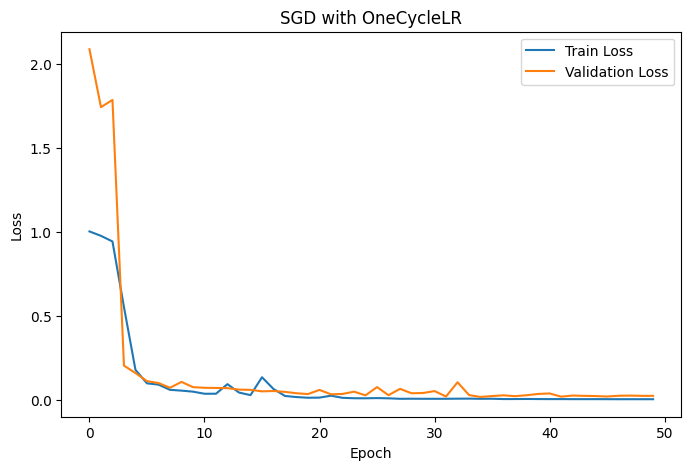


Training with SGD optimizer and CyclicLR scheduler
Epoch 1/50: Train Loss: 1.0285, Val Loss: 2.1382
Epoch 2/50: Train Loss: 0.9959, Val Loss: 1.8752
Epoch 3/50: Train Loss: 0.9918, Val Loss: 1.8776
Epoch 4/50: Train Loss: 0.9778, Val Loss: 1.9161
Epoch 5/50: Train Loss: 0.9603, Val Loss: 1.8550
Epoch 6/50: Train Loss: 0.9346, Val Loss: 1.8279
Epoch 7/50: Train Loss: 0.8745, Val Loss: 1.6943
Epoch 8/50: Train Loss: 0.7602, Val Loss: 1.5221
Epoch 9/50: Train Loss: 0.5235, Val Loss: 1.0609
Epoch 10/50: Train Loss: 0.1990, Val Loss: 0.3680
Epoch 11/50: Train Loss: 0.1197, Val Loss: 0.1771
Epoch 12/50: Train Loss: 0.0831, Val Loss: 0.1695
Epoch 13/50: Train Loss: 0.0712, Val Loss: 0.1248
Epoch 14/50: Train Loss: 0.0614, Val Loss: 0.1115
Epoch 15/50: Train Loss: 0.0529, Val Loss: 0.1034
Epoch 16/50: Train Loss: 0.0493, Val Loss: 0.0961
Epoch 17/50: Train Loss: 0.0477, Val Loss: 0.0859
Epoch 18/50: Train Loss: 0.0440, Val Loss: 0.0797
Epoch 19/50: Train Loss: 0.0409, Val Loss: 0.0768
Epoch 2

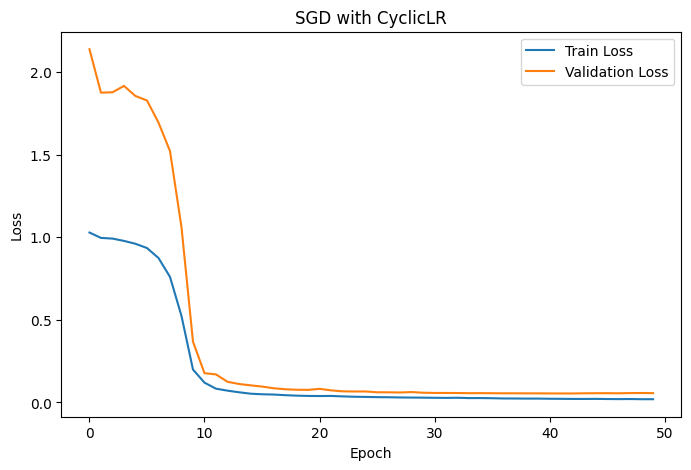


Training with SGD optimizer and ReduceLROnPlateau scheduler
Epoch 1/50: Train Loss: 1.0547, Val Loss: 2.5220
Epoch 2/50: Train Loss: 1.0269, Val Loss: 2.3579
Epoch 3/50: Train Loss: 1.0107, Val Loss: 2.2351
Epoch 4/50: Train Loss: 1.0007, Val Loss: 2.1469
Epoch 5/50: Train Loss: 0.9945, Val Loss: 2.0985
Epoch 6/50: Train Loss: 0.9891, Val Loss: 2.0481
Epoch 7/50: Train Loss: 0.9846, Val Loss: 2.0174
Epoch 8/50: Train Loss: 0.9802, Val Loss: 1.9776
Epoch 9/50: Train Loss: 0.9754, Val Loss: 1.9596
Epoch 10/50: Train Loss: 0.9707, Val Loss: 1.9442
Epoch 11/50: Train Loss: 0.9647, Val Loss: 1.9186
Epoch 12/50: Train Loss: 0.9580, Val Loss: 1.9017
Epoch 13/50: Train Loss: 0.9503, Val Loss: 1.8931
Epoch 14/50: Train Loss: 0.9399, Val Loss: 1.8809
Epoch 15/50: Train Loss: 0.9273, Val Loss: 1.8534
Epoch 16/50: Train Loss: 0.9114, Val Loss: 1.8165
Epoch 17/50: Train Loss: 0.8915, Val Loss: 1.7938
Epoch 18/50: Train Loss: 0.8682, Val Loss: 1.7515
Epoch 19/50: Train Loss: 0.8388, Val Loss: 1.727

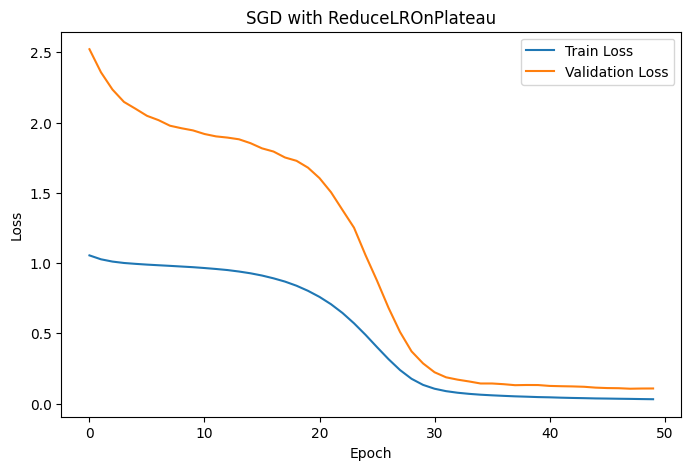


Training with Momentum optimizer and OneCycleLR scheduler
Epoch 1/50: Train Loss: 0.9997, Val Loss: 1.8933
Epoch 2/50: Train Loss: 0.9882, Val Loss: 1.9324
Epoch 3/50: Train Loss: 0.9389, Val Loss: 1.7390
Epoch 4/50: Train Loss: 0.6226, Val Loss: 0.0894
Epoch 5/50: Train Loss: 0.2706, Val Loss: 0.9386
Epoch 6/50: Train Loss: 0.1292, Val Loss: 0.0913
Epoch 7/50: Train Loss: 0.0739, Val Loss: 0.2012
Epoch 8/50: Train Loss: 0.0465, Val Loss: 0.0805
Epoch 9/50: Train Loss: 0.0412, Val Loss: 0.0694
Epoch 10/50: Train Loss: 0.0402, Val Loss: 0.1200
Epoch 11/50: Train Loss: 0.0315, Val Loss: 0.0817
Epoch 12/50: Train Loss: 0.0260, Val Loss: 0.0689
Epoch 13/50: Train Loss: 0.0195, Val Loss: 0.0685
Epoch 14/50: Train Loss: 0.0179, Val Loss: 0.0749
Epoch 15/50: Train Loss: 0.0189, Val Loss: 0.1457
Epoch 16/50: Train Loss: 0.0120, Val Loss: 0.2164
Epoch 17/50: Train Loss: 0.0141, Val Loss: 0.1738
Epoch 18/50: Train Loss: 0.0091, Val Loss: 0.1481
Epoch 19/50: Train Loss: 0.0111, Val Loss: 0.1691


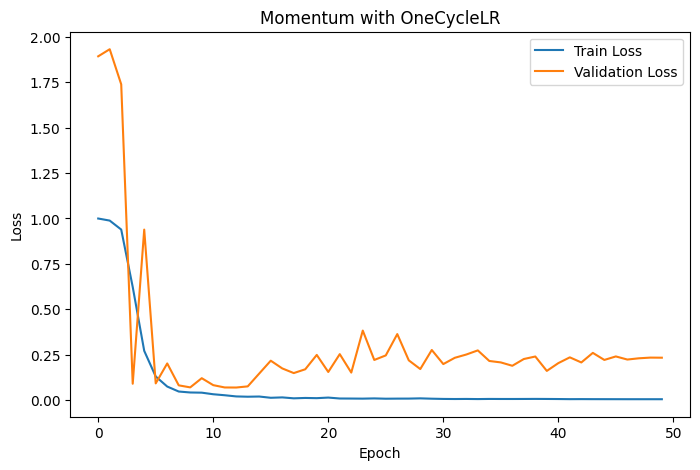


Training with Momentum optimizer and CyclicLR scheduler
Epoch 1/50: Train Loss: 1.0032, Val Loss: 1.9109
Epoch 2/50: Train Loss: 0.9914, Val Loss: 1.9584
Epoch 3/50: Train Loss: 0.9833, Val Loss: 1.8709
Epoch 4/50: Train Loss: 0.9733, Val Loss: 1.8388
Epoch 5/50: Train Loss: 0.9574, Val Loss: 1.7126
Epoch 6/50: Train Loss: 0.9286, Val Loss: 1.7616
Epoch 7/50: Train Loss: 0.8615, Val Loss: 1.6177
Epoch 8/50: Train Loss: 0.7413, Val Loss: 1.0725
Epoch 9/50: Train Loss: 0.5400, Val Loss: 0.4867
Epoch 10/50: Train Loss: 0.2252, Val Loss: 0.0444
Epoch 11/50: Train Loss: 0.1293, Val Loss: 0.0835
Epoch 12/50: Train Loss: 0.0833, Val Loss: 0.0697
Epoch 13/50: Train Loss: 0.0682, Val Loss: 0.0661
Epoch 14/50: Train Loss: 0.0550, Val Loss: 0.0858
Epoch 15/50: Train Loss: 0.0505, Val Loss: 0.0794
Epoch 16/50: Train Loss: 0.0408, Val Loss: 0.0541
Epoch 17/50: Train Loss: 0.0360, Val Loss: 0.0650
Epoch 18/50: Train Loss: 0.0315, Val Loss: 0.0670
Epoch 19/50: Train Loss: 0.0287, Val Loss: 0.0649
Ep

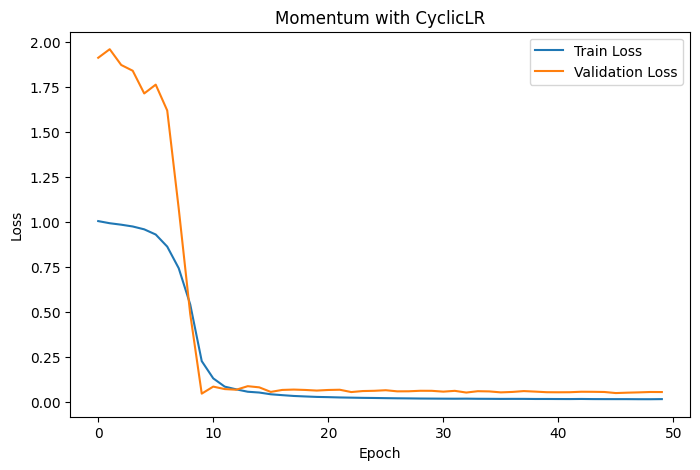


Training with Momentum optimizer and ReduceLROnPlateau scheduler
Epoch 1/50: Train Loss: 1.0116, Val Loss: 1.9360
Epoch 2/50: Train Loss: 0.9935, Val Loss: 1.9876
Epoch 3/50: Train Loss: 0.9948, Val Loss: 1.8672
Epoch 4/50: Train Loss: 0.9658, Val Loss: 1.9347
Epoch 5/50: Train Loss: 0.9151, Val Loss: 1.5359
Epoch 6/50: Train Loss: 0.7116, Val Loss: 0.9905
Epoch 7/50: Train Loss: 0.2283, Val Loss: 0.0577
Epoch 8/50: Train Loss: 0.1155, Val Loss: 0.1192
Epoch 9/50: Train Loss: 0.0724, Val Loss: 0.0671
Epoch 10/50: Train Loss: 0.0602, Val Loss: 0.0642
Epoch 11/50: Train Loss: 0.0529, Val Loss: 0.0700
Epoch 12/50: Train Loss: 0.0382, Val Loss: 0.0661
Epoch 13/50: Train Loss: 0.0306, Val Loss: 0.0738
Epoch 14/50: Train Loss: 0.0276, Val Loss: 0.0722
Epoch 15/50: Train Loss: 0.0270, Val Loss: 0.0731
Epoch 16/50: Train Loss: 0.0264, Val Loss: 0.0772
Epoch 17/50: Train Loss: 0.0256, Val Loss: 0.0739
Epoch 18/50: Train Loss: 0.0253, Val Loss: 0.0726
Epoch 19/50: Train Loss: 0.0246, Val Loss: 

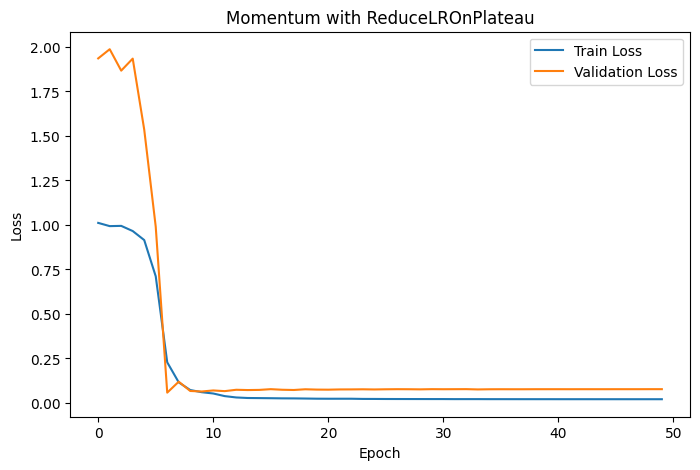


Training with Adam optimizer and OneCycleLR scheduler
Epoch 1/50: Train Loss: 0.9557, Val Loss: 1.1618
Epoch 2/50: Train Loss: 0.4732, Val Loss: 0.1508
Epoch 3/50: Train Loss: 0.1749, Val Loss: 0.1918
Epoch 4/50: Train Loss: 0.0951, Val Loss: 0.2671
Epoch 5/50: Train Loss: 0.0572, Val Loss: 0.1336
Epoch 6/50: Train Loss: 0.0319, Val Loss: 0.1251
Epoch 7/50: Train Loss: 0.0270, Val Loss: 0.1552
Epoch 8/50: Train Loss: 0.0324, Val Loss: 0.0547
Epoch 9/50: Train Loss: 0.0192, Val Loss: 0.1006
Epoch 10/50: Train Loss: 0.0500, Val Loss: 0.2432
Epoch 11/50: Train Loss: 0.0912, Val Loss: 0.0947
Epoch 12/50: Train Loss: 0.1580, Val Loss: 1.7593
Epoch 13/50: Train Loss: 0.5791, Val Loss: 0.5630
Epoch 14/50: Train Loss: 0.9108, Val Loss: 3.9367
Epoch 15/50: Train Loss: 0.5851, Val Loss: 0.0834
Epoch 16/50: Train Loss: 0.3934, Val Loss: 0.3814
Epoch 17/50: Train Loss: 0.3804, Val Loss: 0.8748
Epoch 18/50: Train Loss: 0.2776, Val Loss: 0.1992
Epoch 19/50: Train Loss: 0.2080, Val Loss: 0.3002
Epoc

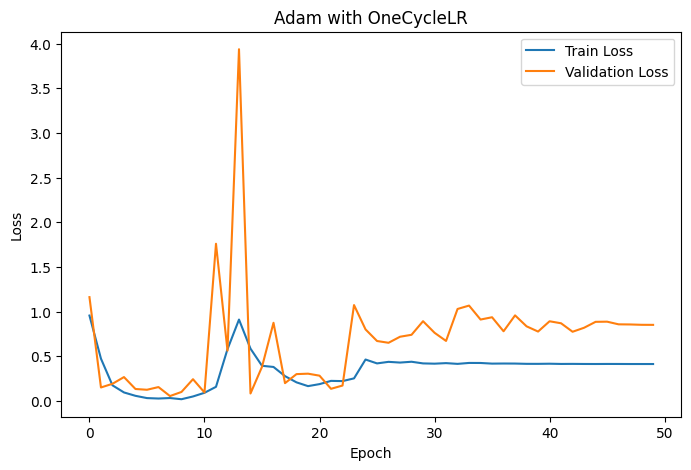


Training with Adam optimizer and CyclicLR scheduler
Epoch 1/50: Train Loss: 0.9240, Val Loss: 1.6381
Epoch 2/50: Train Loss: 0.2053, Val Loss: 0.1311
Epoch 3/50: Train Loss: 0.0602, Val Loss: 0.0391
Epoch 4/50: Train Loss: 0.0397, Val Loss: 0.0365
Epoch 5/50: Train Loss: 0.0301, Val Loss: 0.0367
Epoch 6/50: Train Loss: 0.0267, Val Loss: 0.0345
Epoch 7/50: Train Loss: 0.0217, Val Loss: 0.0336
Epoch 8/50: Train Loss: 0.0171, Val Loss: 0.0391
Epoch 9/50: Train Loss: 0.0151, Val Loss: 0.0542
Epoch 10/50: Train Loss: 0.0141, Val Loss: 0.0361
Epoch 11/50: Train Loss: 0.0122, Val Loss: 0.0452
Epoch 12/50: Train Loss: 0.0116, Val Loss: 0.0484
Epoch 13/50: Train Loss: 0.0100, Val Loss: 0.0596
Epoch 14/50: Train Loss: 0.0100, Val Loss: 0.0635
Epoch 15/50: Train Loss: 0.0111, Val Loss: 0.0676
Epoch 16/50: Train Loss: 0.0084, Val Loss: 0.0738
Epoch 17/50: Train Loss: 0.0086, Val Loss: 0.0747
Epoch 18/50: Train Loss: 0.0077, Val Loss: 0.0785
Epoch 19/50: Train Loss: 0.0069, Val Loss: 0.0662
Epoch 

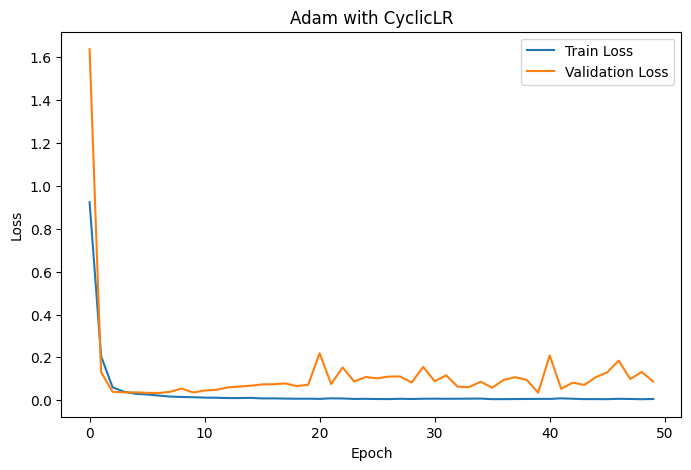


Training with Adam optimizer and ReduceLROnPlateau scheduler
Epoch 1/50: Train Loss: 0.8094, Val Loss: 0.1401
Epoch 2/50: Train Loss: 0.1680, Val Loss: 0.0939
Epoch 3/50: Train Loss: 0.0591, Val Loss: 0.1018
Epoch 4/50: Train Loss: 0.0369, Val Loss: 0.1138
Epoch 5/50: Train Loss: 0.0310, Val Loss: 0.0759
Epoch 6/50: Train Loss: 0.0238, Val Loss: 0.0948
Epoch 7/50: Train Loss: 0.0190, Val Loss: 0.0693
Epoch 8/50: Train Loss: 0.0173, Val Loss: 0.0956
Epoch 9/50: Train Loss: 0.0151, Val Loss: 0.0754
Epoch 10/50: Train Loss: 0.0144, Val Loss: 0.0483
Epoch 11/50: Train Loss: 0.0118, Val Loss: 0.0658
Epoch 12/50: Train Loss: 0.0119, Val Loss: 0.0452
Epoch 13/50: Train Loss: 0.0105, Val Loss: 0.0438
Epoch 14/50: Train Loss: 0.0107, Val Loss: 0.0681
Epoch 15/50: Train Loss: 0.0082, Val Loss: 0.0399
Epoch 16/50: Train Loss: 0.0104, Val Loss: 0.0498
Epoch 17/50: Train Loss: 0.0094, Val Loss: 0.0510
Epoch 18/50: Train Loss: 0.0087, Val Loss: 0.0373
Epoch 19/50: Train Loss: 0.0092, Val Loss: 0.08

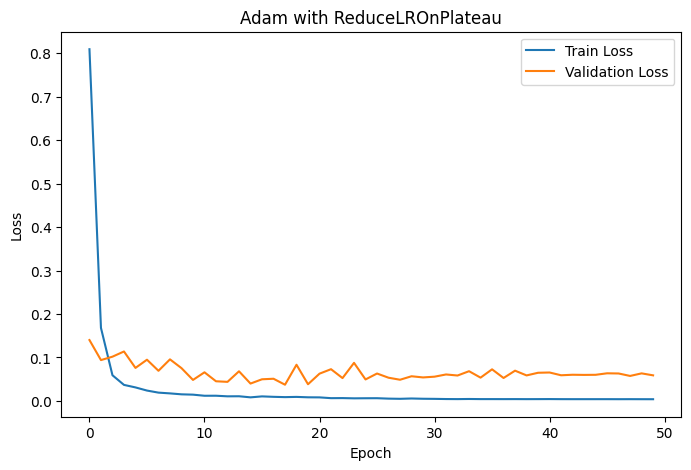

In [17]:
# --- Define Optimizers and Schedulers to Test ---
optimizers_dict = {
    'SGD': lambda params: optim.SGD(params, lr=0.01),
    'Momentum': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'Adam': lambda params: optim.Adam(params, lr=0.01)}

scheduler_types = {
    'OneCycleLR': 'batch',
    'CyclicLR': 'batch',
    'ReduceLROnPlateau': 'plateau'}

# --- Loop over each Optimizer and Scheduler Combination ---
num_epochs = 50
results = {}   # To store losses and final validation loss for each combination
best_val_loss = float('inf')
best_combo = None
best_model_state = None  # To store the best model's parameters

for opt_name, opt_func in optimizers_dict.items():
    results[opt_name] = {}
    for sched_name, sched_step in scheduler_types.items():
        print(f"\nTraining with {opt_name} optimizer and {sched_name} scheduler")
        model = StockNN(input_dim)
        criterion = nn.MSELoss()
        optimizer_instance = opt_func(model.parameters())
        
        # Set up the chosen scheduler
        if sched_name == 'OneCycleLR':
            scheduler = optim.lr_scheduler.OneCycleLR(optimizer_instance, max_lr=0.1, 
                                                      steps_per_epoch=len(train_loader), epochs=num_epochs)
        elif sched_name == 'CyclicLR':
            scheduler = optim.lr_scheduler.CyclicLR(optimizer_instance, base_lr=0.001, max_lr=0.01,
                                                    step_size_up=10)
        elif sched_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_instance, mode='min',
                                                             factor=0.5, patience=5)
        else:
            scheduler = None
        
        # Train the model with the current combination
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer_instance,
                                               scheduler=scheduler, scheduler_type=sched_step, num_epochs=num_epochs)
        final_val_loss = val_losses[-1]
        results[opt_name][sched_name] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'final_val_loss': final_val_loss}
        
        # Update best combination if applicable, and save the best model state
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_combo = (opt_name, sched_name)
            best_model_state = model.state_dict()
            
        # Plot losses for this combination
        plt.figure(figsize=(8,5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{opt_name} with {sched_name}')
        plt.legend()
        plt.show()

### Report your training and testing error

In [18]:
# Output the best combination and final validation loss
print(f"\nBest combination: Optimizer = {best_combo[0]}, Scheduler = {best_combo[1]} with final validation loss = {best_val_loss:.4f}")

# --- Evaluate the Best Model on the Test Set ---
best_model = StockNN(input_dim)
best_model.load_state_dict(best_model_state)
best_model.eval()

# Prepare a test DataLoader
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

# Compute the MSE on the scaled data (for informational purposes)
test_loss_scaled = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        test_loss_scaled += loss.item() * inputs.size(0)
test_loss_scaled /= len(test_loader.dataset)
print(f"Test Loss on scaled data: {test_loss_scaled:.4f}")

# --- Inverse Transform Predictions and Compute MSE in Original Scale ---
best_model.eval()
with torch.no_grad():
    test_predictions = best_model(X_test_tensor).detach().numpy()

# Inverse transform to original scale
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_test_inv = scaler_y.inverse_transform(y_test_tensor.numpy())

# Compute the Mean Squared Error on the original scale
test_mse = np.mean((test_predictions_inv - y_test_inv)**2)
print(f"Test MSE in original scale: {test_mse:.4f}")

# --- Plot Predictions vs True Values for the Test Set ---
best_model.eval()
test_predictions = best_model(X_test_tensor).detach().numpy()
test_predictions = scaler_y.inverse_transform(test_predictions)
y_test_np = scaler_y.inverse_transform(y_test_tensor.numpy())

# Save the model
torch.save(best_model.state_dict(), 'STOCKNN.pth')


Best combination: Optimizer = SGD, Scheduler = OneCycleLR with final validation loss = 0.0256
Test Loss on scaled data: 0.7192
Test MSE in original scale: 2515.1306


---

## Part 3) Try to design a network using not more parameters than the constructed one.

### 1. Split the MSFT stock price data into training (1/1/2023-6/30/2024), validation (7/1/2024-10/31/2024), and test (11/1/2024-12/31/2024) datasets.

In [19]:
# --- Data Loading Functions ---
def get_price(tick, start, end):
    return yf.Ticker(tick).history(start=start, end=end)['Close']

def get_prices(tickers, start, end):
    return pd.DataFrame({s: get_price(s, start, end) for s in tickers})

# --- Define the Stocks and Date Ranges ---
feature_stocks = ['tsla','meta','goog','amzn','nflx','gbtc','gdx','intc','dal','c']
predict_stock = 'msft'

dates = {
    'train': ('2023-01-01', '2024-06-30'),
    'val':   ('2024-07-01', '2024-10-31'),
    'test':  ('2024-11-01', '2024-12-31')
}

X_train = get_prices(feature_stocks, *dates['train'])
y_train = get_prices([predict_stock], *dates['train'])
X_val   = get_prices(feature_stocks, *dates['val'])
y_val   = get_prices([predict_stock], *dates['val'])
X_test  = get_prices(feature_stocks, *dates['test'])
y_test  = get_prices([predict_stock], *dates['test'])

In [20]:
# Align the dataframes by index
X_train, y_train = X_train.align(y_train, join='inner', axis=0)
X_val, y_val     = X_val.align(y_val, join='inner', axis=0)
X_test, y_test   = X_test.align(y_test, join='inner', axis=0)

# --- Convert, Scale, and Transform to Torch Tensors ---
X_train_np = X_train.values.astype(np.float32)
y_train_np = y_train.values.astype(np.float32)
X_val_np   = X_val.values.astype(np.float32)
y_val_np   = y_val.values.astype(np.float32)
X_test_np  = X_test.values.astype(np.float32)
y_test_np  = y_test.values.astype(np.float32)

# Scale features (fit only on train data)
scaler_X = StandardScaler().fit(X_train_np)
scaler_y = StandardScaler().fit(y_train_np)
X_train_tensor = torch.tensor(scaler_X.transform(X_train_np))
y_train_tensor = torch.tensor(scaler_y.transform(y_train_np))
X_val_tensor   = torch.tensor(scaler_X.transform(X_val_np))
y_val_tensor   = torch.tensor(scaler_y.transform(y_val_np))
X_test_tensor  = torch.tensor(scaler_X.transform(X_test_np))
y_test_tensor  = torch.tensor(scaler_y.transform(y_test_np))

In [21]:
# --- Create DataLoaders ---
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

# Helper function to count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [22]:
# --- Standard Model for Reference ---
class StockNN(nn.Module):
    def __init__(self, input_dim):
        super(StockNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 20), nn.ReLU(),
            nn.Linear(20, 1)
        )
    def forward(self, x):
        return self.model(x)

# For feature_stocks, input_dim = 10.
input_dim = 10
standard_model = StockNN(input_dim)
print("Standard Model Parameters:", count_parameters(standard_model))

Standard Model Parameters: 1921


### 2. Estimate the MSFT stock price again using Residual Blocks, SELU, and BatchNorm

In [23]:
# --- Advanced Model Using Residual Blocks, SELU, and BatchNorm ---
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_p=0.1):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.act = nn.SELU()
        self.drop = nn.AlphaDropout(dropout_p)
        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.act(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.act(out)
        out = self.drop(out)
        return out + residual  # Skip connection

class AdvancedStockNN(nn.Module):
    def __init__(self, input_dim):
        super(AdvancedStockNN, self).__init__()
        # First layer: project from input_dim to a hidden size (we choose 16)
        self.fc1 = nn.Linear(input_dim, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.act = nn.SELU()
        self.drop = nn.AlphaDropout(0.1)
        # Two residual blocks in sequence
        self.resblock1 = ResidualBlock(16, dropout_p=0.1)
        self.resblock2 = ResidualBlock(16, dropout_p=0.1)
        # Final output layer
        self.fc_out = nn.Linear(16, 1)
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.fc_out(x)
        return x

advanced_model = AdvancedStockNN(input_dim)
print("Advanced Model Parameters:", count_parameters(advanced_model))

Advanced Model Parameters: 1441


In [24]:
# --- Training Loop for Advanced Model ---
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, scheduler_type='batch', num_epochs=50):
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            if scheduler is not None and scheduler_type == 'batch':
                scheduler.step()
            epoch_train_loss += loss.item() * inputs.size(0)
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)
        
        model.eval()
        epoch_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                epoch_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        if scheduler is not None and scheduler_type == 'plateau':
            scheduler.step(epoch_val_loss)
            
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
    return train_losses, val_losses

### 3. Try different optimization algorithms, SGD, Momentum, Adam. Plot the training loss/validation loss VS epoch.

### Set learning rate schedulers using OneCycleLR, CyclicLR, and ReduceLROnPlateau.


Training with SGD optimizer and OneCycleLR scheduler
Epoch 1/50: Train Loss: 1.6479, Val Loss: 0.1348
Epoch 2/50: Train Loss: 0.4319, Val Loss: 0.0633
Epoch 3/50: Train Loss: 0.2817, Val Loss: 0.0672
Epoch 4/50: Train Loss: 0.2896, Val Loss: 0.1418
Epoch 5/50: Train Loss: 0.2796, Val Loss: 0.5073
Epoch 6/50: Train Loss: 0.1823, Val Loss: 0.1227
Epoch 7/50: Train Loss: 0.2594, Val Loss: 0.7882
Epoch 8/50: Train Loss: 0.4076, Val Loss: 0.9170
Epoch 9/50: Train Loss: 0.2830, Val Loss: 0.0695
Epoch 10/50: Train Loss: 0.2069, Val Loss: 0.6326
Epoch 11/50: Train Loss: 0.2807, Val Loss: 0.1706
Epoch 12/50: Train Loss: 0.2108, Val Loss: 1.1411
Epoch 13/50: Train Loss: 0.3954, Val Loss: 1.9641
Epoch 14/50: Train Loss: 0.3705, Val Loss: 1.3326
Epoch 15/50: Train Loss: 0.3285, Val Loss: 0.3820
Epoch 16/50: Train Loss: 0.3240, Val Loss: 0.7893
Epoch 17/50: Train Loss: 0.2545, Val Loss: 0.0263
Epoch 18/50: Train Loss: 0.2969, Val Loss: 0.1144
Epoch 19/50: Train Loss: 0.2730, Val Loss: 0.9303
Epoch

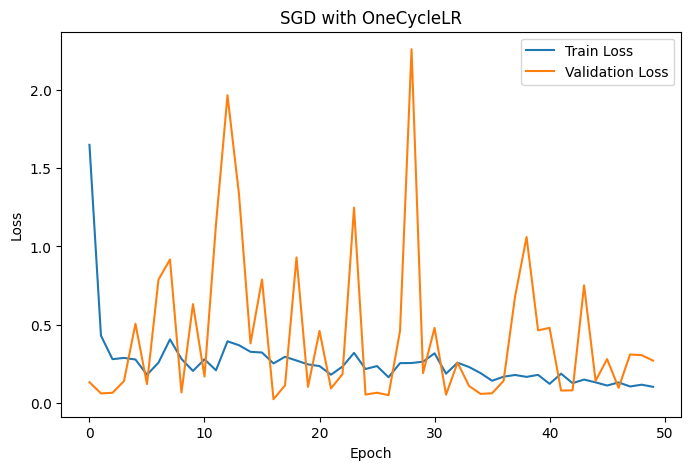


Training with SGD optimizer and CyclicLR scheduler
Epoch 1/50: Train Loss: 1.1461, Val Loss: 0.7976
Epoch 2/50: Train Loss: 0.4883, Val Loss: 0.3100
Epoch 3/50: Train Loss: 0.3099, Val Loss: 0.1488
Epoch 4/50: Train Loss: 0.2231, Val Loss: 0.0723
Epoch 5/50: Train Loss: 0.2200, Val Loss: 0.0361
Epoch 6/50: Train Loss: 0.1877, Val Loss: 0.1144
Epoch 7/50: Train Loss: 0.1818, Val Loss: 0.1135
Epoch 8/50: Train Loss: 0.1696, Val Loss: 0.0488
Epoch 9/50: Train Loss: 0.1552, Val Loss: 0.0319
Epoch 10/50: Train Loss: 0.1632, Val Loss: 0.0563
Epoch 11/50: Train Loss: 0.1380, Val Loss: 0.1334
Epoch 12/50: Train Loss: 0.1770, Val Loss: 0.0486
Epoch 13/50: Train Loss: 0.1502, Val Loss: 0.0384
Epoch 14/50: Train Loss: 0.1625, Val Loss: 0.1411
Epoch 15/50: Train Loss: 0.1673, Val Loss: 0.0399
Epoch 16/50: Train Loss: 0.1865, Val Loss: 0.1426
Epoch 17/50: Train Loss: 0.1417, Val Loss: 0.0811
Epoch 18/50: Train Loss: 0.1514, Val Loss: 0.0761
Epoch 19/50: Train Loss: 0.1502, Val Loss: 0.0769
Epoch 2

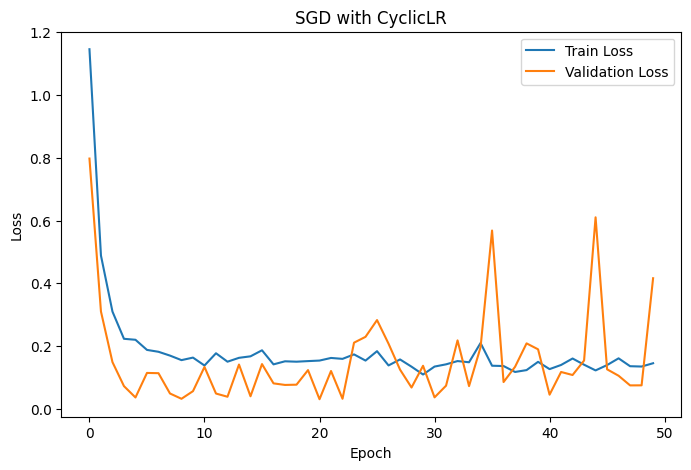


Training with SGD optimizer and ReduceLROnPlateau scheduler
Epoch 1/50: Train Loss: 1.7198, Val Loss: 3.4728
Epoch 2/50: Train Loss: 1.0657, Val Loss: 2.5142
Epoch 3/50: Train Loss: 0.6664, Val Loss: 1.3327
Epoch 4/50: Train Loss: 0.5459, Val Loss: 0.9534
Epoch 5/50: Train Loss: 0.4971, Val Loss: 0.7984
Epoch 6/50: Train Loss: 0.4120, Val Loss: 0.4749
Epoch 7/50: Train Loss: 0.3521, Val Loss: 0.3166
Epoch 8/50: Train Loss: 0.3722, Val Loss: 0.2991
Epoch 9/50: Train Loss: 0.3184, Val Loss: 0.1530
Epoch 10/50: Train Loss: 0.2840, Val Loss: 0.2475
Epoch 11/50: Train Loss: 0.3036, Val Loss: 0.1473
Epoch 12/50: Train Loss: 0.2704, Val Loss: 0.2225
Epoch 13/50: Train Loss: 0.2202, Val Loss: 0.1830
Epoch 14/50: Train Loss: 0.2265, Val Loss: 0.1496
Epoch 15/50: Train Loss: 0.2200, Val Loss: 0.1433
Epoch 16/50: Train Loss: 0.1993, Val Loss: 0.1147
Epoch 17/50: Train Loss: 0.2182, Val Loss: 0.1061
Epoch 18/50: Train Loss: 0.2456, Val Loss: 0.1410
Epoch 19/50: Train Loss: 0.1902, Val Loss: 0.102

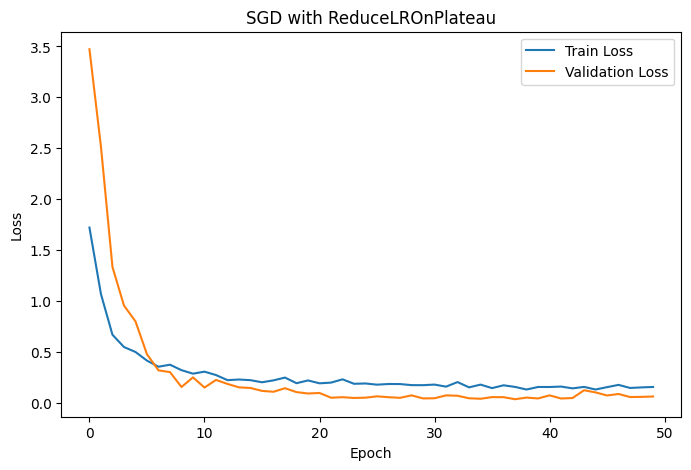


Training with Momentum optimizer and OneCycleLR scheduler
Epoch 1/50: Train Loss: 2.0391, Val Loss: 0.2458
Epoch 2/50: Train Loss: 0.5001, Val Loss: 0.3675
Epoch 3/50: Train Loss: 0.3517, Val Loss: 0.9410
Epoch 4/50: Train Loss: 0.2834, Val Loss: 0.5294
Epoch 5/50: Train Loss: 0.2676, Val Loss: 0.3926
Epoch 6/50: Train Loss: 0.2700, Val Loss: 0.0577
Epoch 7/50: Train Loss: 0.2798, Val Loss: 0.1793
Epoch 8/50: Train Loss: 0.3152, Val Loss: 0.0495
Epoch 9/50: Train Loss: 0.3289, Val Loss: 0.0627
Epoch 10/50: Train Loss: 0.3284, Val Loss: 0.4021
Epoch 11/50: Train Loss: 0.2710, Val Loss: 0.9669
Epoch 12/50: Train Loss: 0.3144, Val Loss: 0.9610
Epoch 13/50: Train Loss: 0.2785, Val Loss: 0.9132
Epoch 14/50: Train Loss: 0.2492, Val Loss: 0.2163
Epoch 15/50: Train Loss: 0.2003, Val Loss: 0.0583
Epoch 16/50: Train Loss: 0.2229, Val Loss: 0.3717
Epoch 17/50: Train Loss: 0.2099, Val Loss: 0.3155
Epoch 18/50: Train Loss: 0.2078, Val Loss: 0.0641
Epoch 19/50: Train Loss: 0.1741, Val Loss: 0.0718


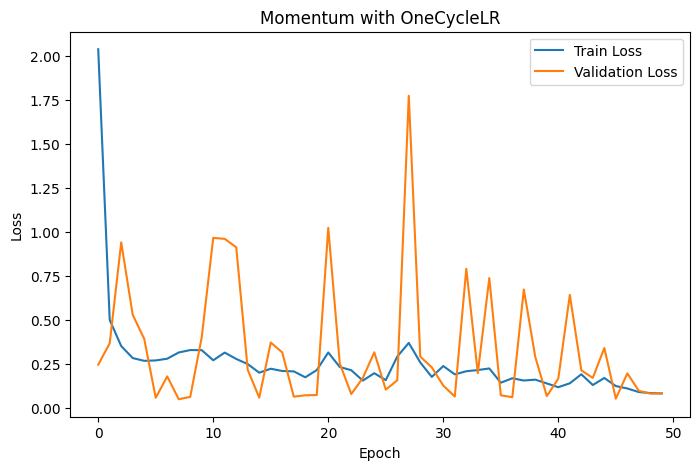


Training with Momentum optimizer and CyclicLR scheduler
Epoch 1/50: Train Loss: 1.0833, Val Loss: 0.1152
Epoch 2/50: Train Loss: 0.3915, Val Loss: 0.0455
Epoch 3/50: Train Loss: 0.2893, Val Loss: 0.0943
Epoch 4/50: Train Loss: 0.2494, Val Loss: 0.1806
Epoch 5/50: Train Loss: 0.2411, Val Loss: 0.2781
Epoch 6/50: Train Loss: 0.2114, Val Loss: 0.2073
Epoch 7/50: Train Loss: 0.1927, Val Loss: 0.1500
Epoch 8/50: Train Loss: 0.1881, Val Loss: 0.2242
Epoch 9/50: Train Loss: 0.1770, Val Loss: 0.2318
Epoch 10/50: Train Loss: 0.1690, Val Loss: 0.0850
Epoch 11/50: Train Loss: 0.1572, Val Loss: 0.4199
Epoch 12/50: Train Loss: 0.1628, Val Loss: 0.1970
Epoch 13/50: Train Loss: 0.1846, Val Loss: 0.2101
Epoch 14/50: Train Loss: 0.1559, Val Loss: 0.0260
Epoch 15/50: Train Loss: 0.1567, Val Loss: 0.1052
Epoch 16/50: Train Loss: 0.1537, Val Loss: 0.5656
Epoch 17/50: Train Loss: 0.1318, Val Loss: 0.1313
Epoch 18/50: Train Loss: 0.1714, Val Loss: 0.1358
Epoch 19/50: Train Loss: 0.1273, Val Loss: 0.2302
Ep

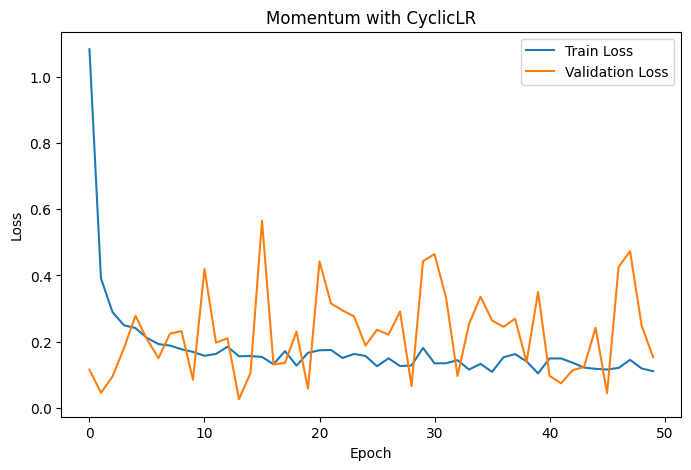


Training with Momentum optimizer and ReduceLROnPlateau scheduler
Epoch 1/50: Train Loss: 1.1100, Val Loss: 0.8492
Epoch 2/50: Train Loss: 0.2786, Val Loss: 0.0771
Epoch 3/50: Train Loss: 0.2324, Val Loss: 0.1994
Epoch 4/50: Train Loss: 0.2199, Val Loss: 0.1332
Epoch 5/50: Train Loss: 0.1693, Val Loss: 0.0882
Epoch 6/50: Train Loss: 0.2378, Val Loss: 0.2440
Epoch 7/50: Train Loss: 0.1551, Val Loss: 0.0305
Epoch 8/50: Train Loss: 0.1720, Val Loss: 0.0747
Epoch 9/50: Train Loss: 0.1828, Val Loss: 0.0334
Epoch 10/50: Train Loss: 0.1574, Val Loss: 0.2699
Epoch 11/50: Train Loss: 0.1598, Val Loss: 0.1242
Epoch 12/50: Train Loss: 0.1519, Val Loss: 0.0841
Epoch 13/50: Train Loss: 0.1398, Val Loss: 0.0917
Epoch 14/50: Train Loss: 0.1628, Val Loss: 0.0511
Epoch 15/50: Train Loss: 0.1322, Val Loss: 0.1449
Epoch 16/50: Train Loss: 0.1300, Val Loss: 0.2626
Epoch 17/50: Train Loss: 0.1474, Val Loss: 0.1103
Epoch 18/50: Train Loss: 0.1505, Val Loss: 0.2093
Epoch 19/50: Train Loss: 0.1424, Val Loss: 

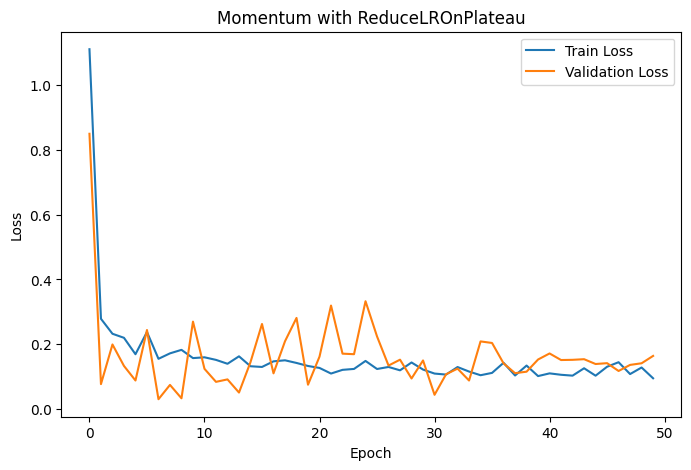


Training with Adam optimizer and OneCycleLR scheduler
Epoch 1/50: Train Loss: 0.4762, Val Loss: 0.3301
Epoch 2/50: Train Loss: 0.3903, Val Loss: 0.0426
Epoch 3/50: Train Loss: 0.2109, Val Loss: 0.2029
Epoch 4/50: Train Loss: 0.1601, Val Loss: 0.2789
Epoch 5/50: Train Loss: 0.1283, Val Loss: 0.1137
Epoch 6/50: Train Loss: 0.1631, Val Loss: 0.5509
Epoch 7/50: Train Loss: 0.1305, Val Loss: 0.1902
Epoch 8/50: Train Loss: 0.1159, Val Loss: 0.0467
Epoch 9/50: Train Loss: 0.1368, Val Loss: 0.6756
Epoch 10/50: Train Loss: 0.1827, Val Loss: 0.1855
Epoch 11/50: Train Loss: 0.1878, Val Loss: 2.6491
Epoch 12/50: Train Loss: 0.1665, Val Loss: 0.5491
Epoch 13/50: Train Loss: 0.1842, Val Loss: 0.1084
Epoch 14/50: Train Loss: 0.1953, Val Loss: 0.5410
Epoch 15/50: Train Loss: 0.1697, Val Loss: 0.1268
Epoch 16/50: Train Loss: 0.2685, Val Loss: 0.1077
Epoch 17/50: Train Loss: 0.2435, Val Loss: 0.5422
Epoch 18/50: Train Loss: 0.1883, Val Loss: 0.8034
Epoch 19/50: Train Loss: 0.1972, Val Loss: 0.0864
Epoc

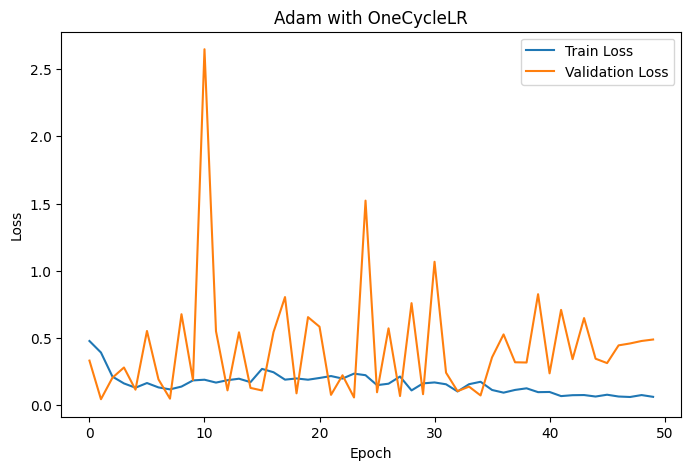


Training with Adam optimizer and CyclicLR scheduler
Epoch 1/50: Train Loss: 0.8874, Val Loss: 0.2484
Epoch 2/50: Train Loss: 0.3103, Val Loss: 0.0968
Epoch 3/50: Train Loss: 0.2191, Val Loss: 0.1100
Epoch 4/50: Train Loss: 0.1656, Val Loss: 0.6359
Epoch 5/50: Train Loss: 0.1263, Val Loss: 0.0273
Epoch 6/50: Train Loss: 0.1446, Val Loss: 0.1930
Epoch 7/50: Train Loss: 0.1162, Val Loss: 0.3589
Epoch 8/50: Train Loss: 0.1660, Val Loss: 0.2131
Epoch 9/50: Train Loss: 0.1161, Val Loss: 0.9280
Epoch 10/50: Train Loss: 0.1216, Val Loss: 1.0709
Epoch 11/50: Train Loss: 0.1202, Val Loss: 0.5181
Epoch 12/50: Train Loss: 0.1115, Val Loss: 0.7727
Epoch 13/50: Train Loss: 0.1181, Val Loss: 0.5982
Epoch 14/50: Train Loss: 0.1131, Val Loss: 0.1943
Epoch 15/50: Train Loss: 0.1350, Val Loss: 0.5013
Epoch 16/50: Train Loss: 0.1134, Val Loss: 0.4553
Epoch 17/50: Train Loss: 0.0986, Val Loss: 0.6921
Epoch 18/50: Train Loss: 0.1066, Val Loss: 0.5358
Epoch 19/50: Train Loss: 0.0838, Val Loss: 0.6229
Epoch 

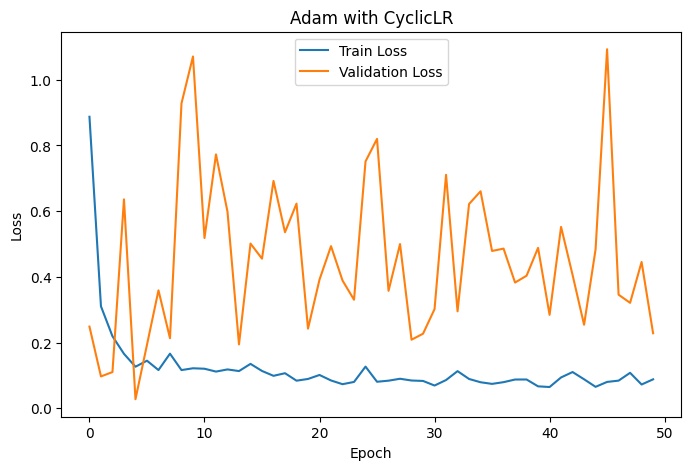


Training with Adam optimizer and ReduceLROnPlateau scheduler
Epoch 1/50: Train Loss: 0.6077, Val Loss: 0.2533
Epoch 2/50: Train Loss: 0.2198, Val Loss: 0.0795
Epoch 3/50: Train Loss: 0.1429, Val Loss: 0.1508
Epoch 4/50: Train Loss: 0.1540, Val Loss: 0.1162
Epoch 5/50: Train Loss: 0.1405, Val Loss: 0.1201
Epoch 6/50: Train Loss: 0.1297, Val Loss: 0.4962
Epoch 7/50: Train Loss: 0.1271, Val Loss: 1.0622
Epoch 8/50: Train Loss: 0.1317, Val Loss: 0.4988
Epoch 9/50: Train Loss: 0.1133, Val Loss: 0.1052
Epoch 10/50: Train Loss: 0.1034, Val Loss: 0.5260
Epoch 11/50: Train Loss: 0.0796, Val Loss: 0.1382
Epoch 12/50: Train Loss: 0.0940, Val Loss: 0.9002
Epoch 13/50: Train Loss: 0.1080, Val Loss: 0.1993
Epoch 14/50: Train Loss: 0.0874, Val Loss: 0.5576
Epoch 15/50: Train Loss: 0.0951, Val Loss: 0.4536
Epoch 16/50: Train Loss: 0.0941, Val Loss: 0.5198
Epoch 17/50: Train Loss: 0.0862, Val Loss: 0.4349
Epoch 18/50: Train Loss: 0.1162, Val Loss: 0.3368
Epoch 19/50: Train Loss: 0.0717, Val Loss: 0.38

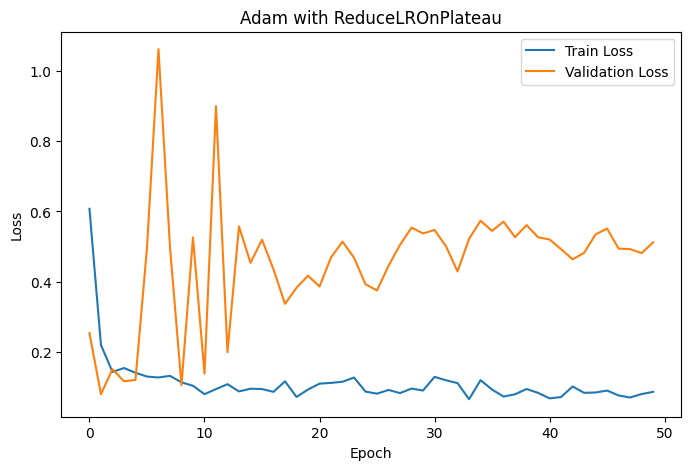

In [25]:
# --- Define Optimizers and Schedulers to Test ---
optimizers_dict = {
    'SGD': lambda params: optim.SGD(params, lr=0.01),
    'Momentum': lambda params: optim.SGD(params, lr=0.01, momentum=0.9),
    'Adam': lambda params: optim.Adam(params, lr=0.01)}

scheduler_types = {
    'OneCycleLR': 'batch',
    'CyclicLR': 'batch',
    'ReduceLROnPlateau': 'plateau'}

# --- Loop over each Optimizer and Scheduler Combination ---
num_epochs = 50
results = {}   # To store losses and final validation loss for each combination
best_val_loss = float('inf')
best_combo = None
best_model_state = None  # To store the best model's parameters

for opt_name, opt_func in optimizers_dict.items():
    results[opt_name] = {}
    for sched_name, sched_step in scheduler_types.items():
        print(f"\nTraining with {opt_name} optimizer and {sched_name} scheduler")
        model = AdvancedStockNN(input_dim)
        criterion = nn.MSELoss()
        optimizer_instance = opt_func(model.parameters())
        
        # Set up the chosen scheduler
        if sched_name == 'OneCycleLR':
            scheduler = optim.lr_scheduler.OneCycleLR(optimizer_instance, max_lr=0.1, 
                                                      steps_per_epoch=len(train_loader), epochs=num_epochs)
        elif sched_name == 'CyclicLR':
            scheduler = optim.lr_scheduler.CyclicLR(optimizer_instance, base_lr=0.001, max_lr=0.01,
                                                    step_size_up=10)
        elif sched_name == 'ReduceLROnPlateau':
            scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer_instance, mode='min',
                                                             factor=0.5, patience=5)
        else:
            scheduler = None
        
        # Train the model with the current combination
        train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer_instance,
                                               scheduler=scheduler, scheduler_type=sched_step, num_epochs=num_epochs)
        final_val_loss = val_losses[-1]
        results[opt_name][sched_name] = {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'final_val_loss': final_val_loss}
        
        # Update best combination if applicable, and save the best model state
        if final_val_loss < best_val_loss:
            best_val_loss = final_val_loss
            best_combo = (opt_name, sched_name)
            best_model_state = model.state_dict()
            
        # Plot losses for this combination
        plt.figure(figsize=(8,5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(f'{opt_name} with {sched_name}')
        plt.legend()
        plt.show()

### Report your training and testing error

In [26]:
# --- Evaluate the Best Model on the Test Set ---
best_model = AdvancedStockNN(input_dim)
best_model.load_state_dict(best_model_state)
best_model.eval()

# Prepare a test DataLoader
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

# Compute the MSE on the scaled data (for informational purposes)
test_loss_scaled = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = best_model(inputs)
        loss = criterion(outputs, targets)
        test_loss_scaled += loss.item() * inputs.size(0)
test_loss_scaled /= len(test_loader.dataset)
print(f"Test Loss on scaled data: {test_loss_scaled:.4f}")

# --- Inverse Transform Predictions and Compute MSE in Original Scale ---
best_model.eval()
with torch.no_grad():
    test_predictions = best_model(X_test_tensor).detach().numpy()

# Inverse transform to original scale
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_test_inv = scaler_y.inverse_transform(y_test_tensor.numpy())

# Compute the Mean Squared Error on the original scale
test_mse = np.mean((test_predictions_inv - y_test_inv)**2)
print(f"Test MSE in original scale: {test_mse:.4f}")

# --- Plot Predictions vs True Values for the Test Set ---
best_model.eval()
test_predictions = best_model(X_test_tensor).detach().numpy()
test_predictions = scaler_y.inverse_transform(test_predictions)
y_test_np = scaler_y.inverse_transform(y_test_tensor.numpy())

# Save the model
torch.save(best_model.state_dict(), 'ADVANCED_STOCKNN.pth')

Test Loss on scaled data: 0.1073
Test MSE in original scale: 375.2627
